# Let's get started! ⚡

## Import Module

### Basic Module

In [1]:
# Exploratory Data Analysis
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import ydata_profiling

# Warnings
import warnings
warnings.filterwarnings('ignore')

### Visualization

In [2]:
# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
palette = sns.color_palette()

### Regrassion Models

In [3]:
# Regrassion Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso # linear regression

# Data Reading

In [4]:
car_df = pd.read_csv('CarPrice.csv')
car_df.head(3)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0


# Exploratory Data Analysis

In [5]:
# car_profile = car_df.profile_report()
# car_profile.to_file('./car_report.html')

# Data Preprocessing

## 원본 복제

In [6]:
# 원본 복제
car_df_org = car_df.copy()

## 컬럼 정리

In [7]:
# 'CarName'에서 회사명과 모델명 분리
def carname_to_maker(name):
    company = name.split(' ')[0]
    return company

def carname_to_model(name):
    model = name.split(' ')[-1]
    if model == '':
        model = name.split(' ')[0]
    return model

car_df['CarMaker'] = car_df['CarName'].map(carname_to_maker)
car_df['CarModel'] = car_df['CarName'].map(carname_to_model)
car_df.drop(['CarName'], axis=1, inplace=True)

In [8]:
# 차량별 고유특성 컬럼들 드랍
def drop_unique_feature_columns(df=None):
    unique_feature_columns = ['car_ID']
    car_df.drop(columns=unique_feature_columns, inplace=True)
    return df

car_df = drop_unique_feature_columns(car_df)

In [9]:
# 원핫 인코딩
def one_hot_encoder(df=None):
    df = pd.get_dummies(df)
    return df

car_df_ohe = one_hot_encoder(car_df)

# 1차 회귀모델 구축

## 데이터와 답 분리

In [10]:
# 데이터와 답 분리
from sklearn.model_selection import train_test_split

X_features = car_df_ohe.drop('price', axis=1)
y_target = car_df_ohe['price']

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.2, random_state=42
)

## 오차 함수 선언

In [24]:
# 오차 함수 선언
from sklearn.metrics import mean_squared_error

def rmse(y_test, pred):
    return np.sqrt(mean_squared_error(y_test,pred))

def evaluate_regr(y_test, pred):
    rmse_val = rmse(y_test, pred)
    return rmse_val

## 학습 및 예측

In [25]:
def fit_pred_eval_model(model=None, X_train=None, X_test=None, y_train=None, y_test=None):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse_val = evaluate_regr(y_test, pred)
    print(f'{model.__class__.__name__} RMSE : {rmse_val:.3f}')
    return

In [26]:
lr_reg = LinearRegression()
rd_reg = Ridge()

fit_pred_eval_model(lr_reg, X_train, X_test, y_train, y_test)
fit_pred_eval_model(rd_reg, X_train, X_test, y_train, y_test)

LinearRegression RMSE : 3528.034
Ridge RMSE : 2841.469


## 피쳐 중요도 시각화

In [36]:
def visualize_coefficient(model, X_features):
    fig, axs = plt.subplots(figsize=(24,10))
    fig.tight_layout()
    
    coeff = pd.Series(index = X_features.columns, data = model.coef_)
    top20 =coeff[:20].sort_values(ascending=False)
    
    axs.set_title(f'{model.__class__.__name__} Coefficents', size=25)
    axs.tick_params(axis='y', direction='in', pad=20)
    for label in (axs.get_xticklabels() + axs.get_yticklabels()):
        label.set_fontsize(22)
    sns.barplot(x=top20.values, y=top20.index, ax=axs)
    return

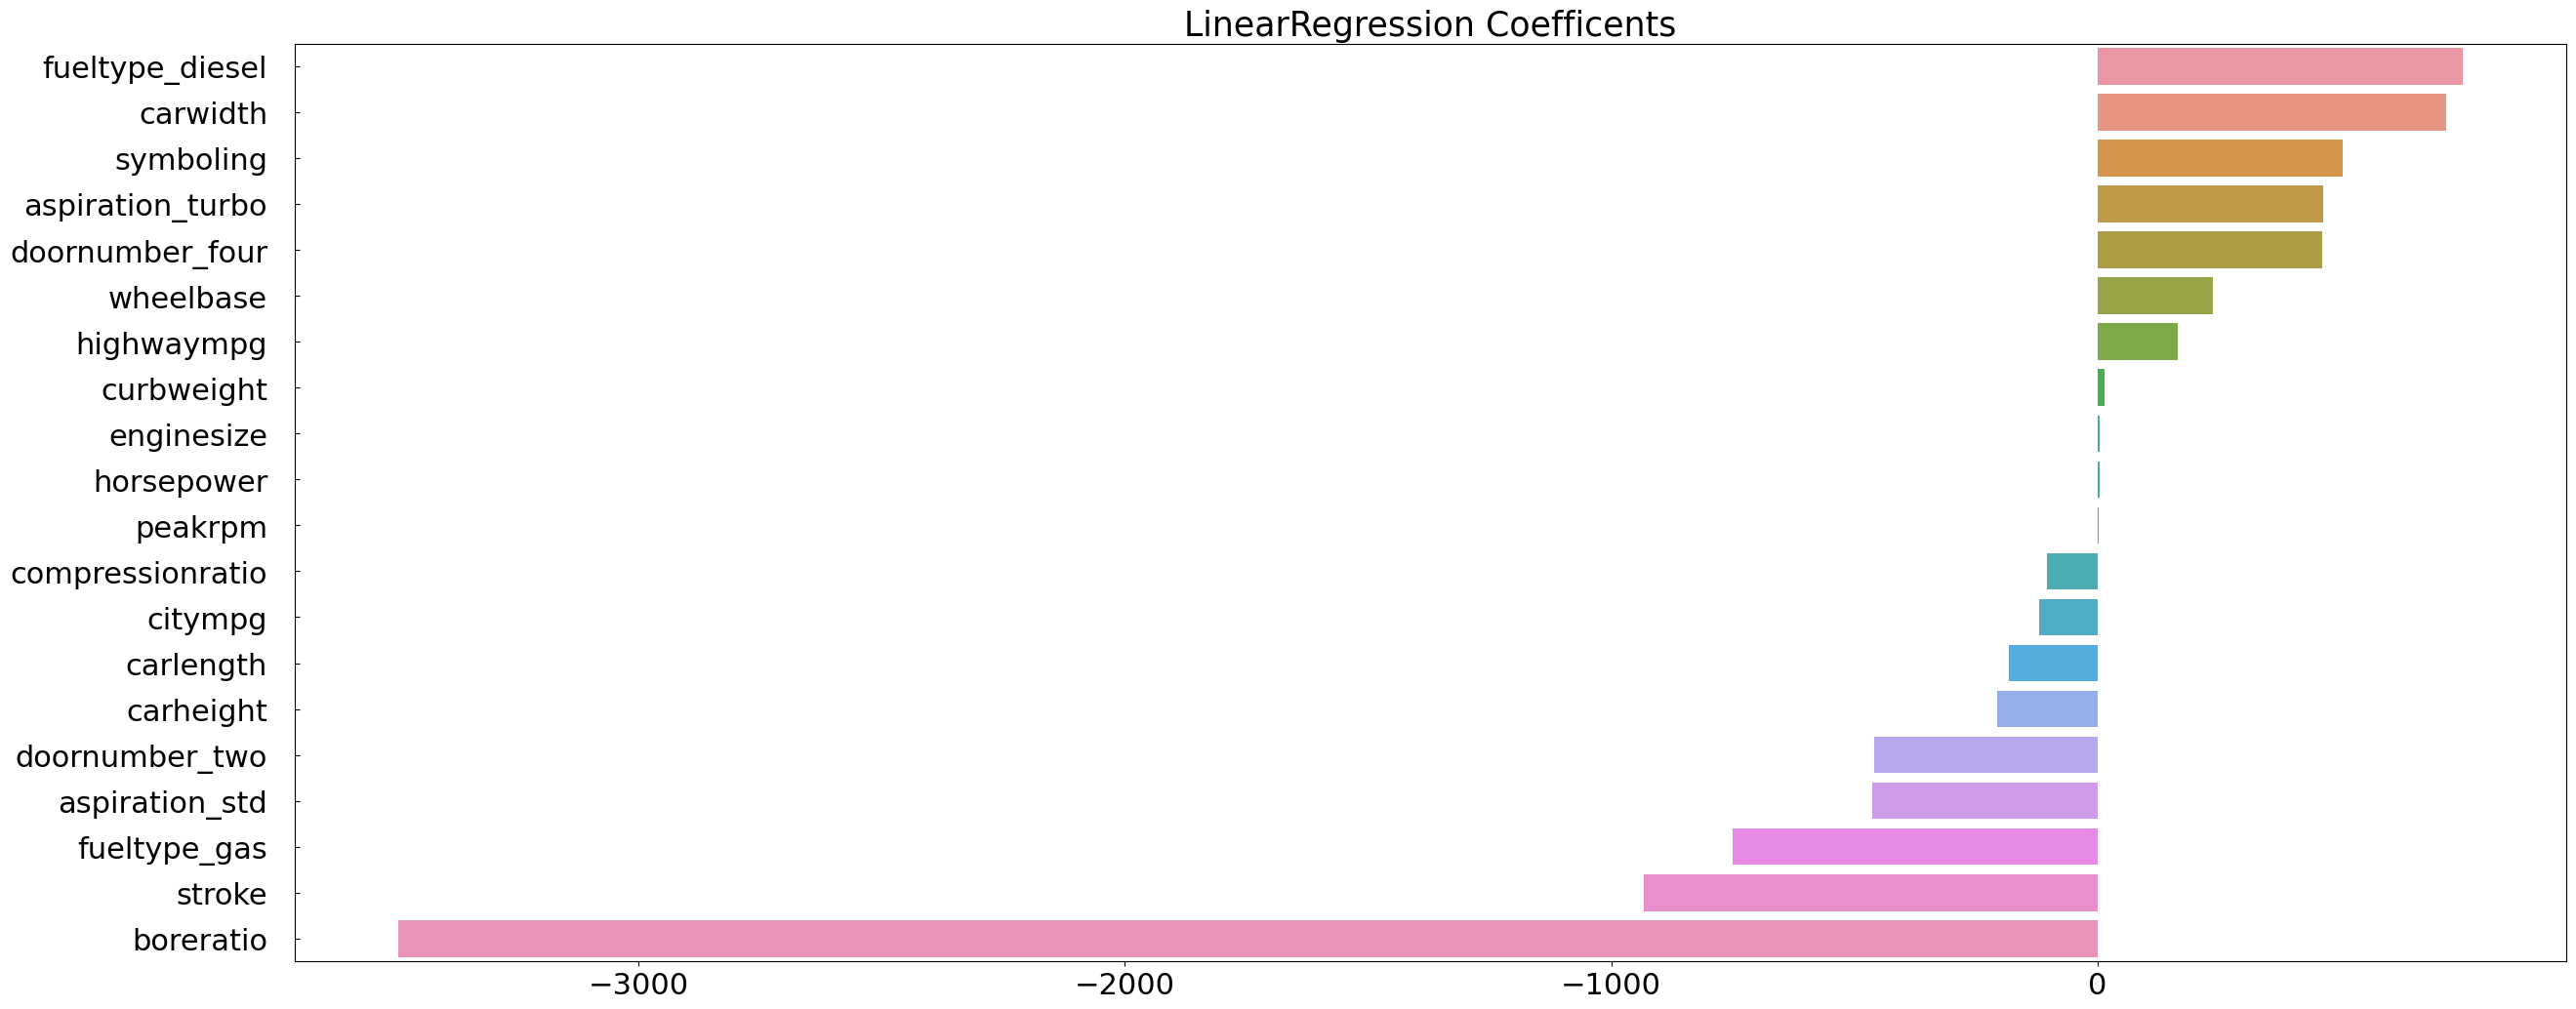

In [37]:
visualize_coefficient(lr_reg, X_features)

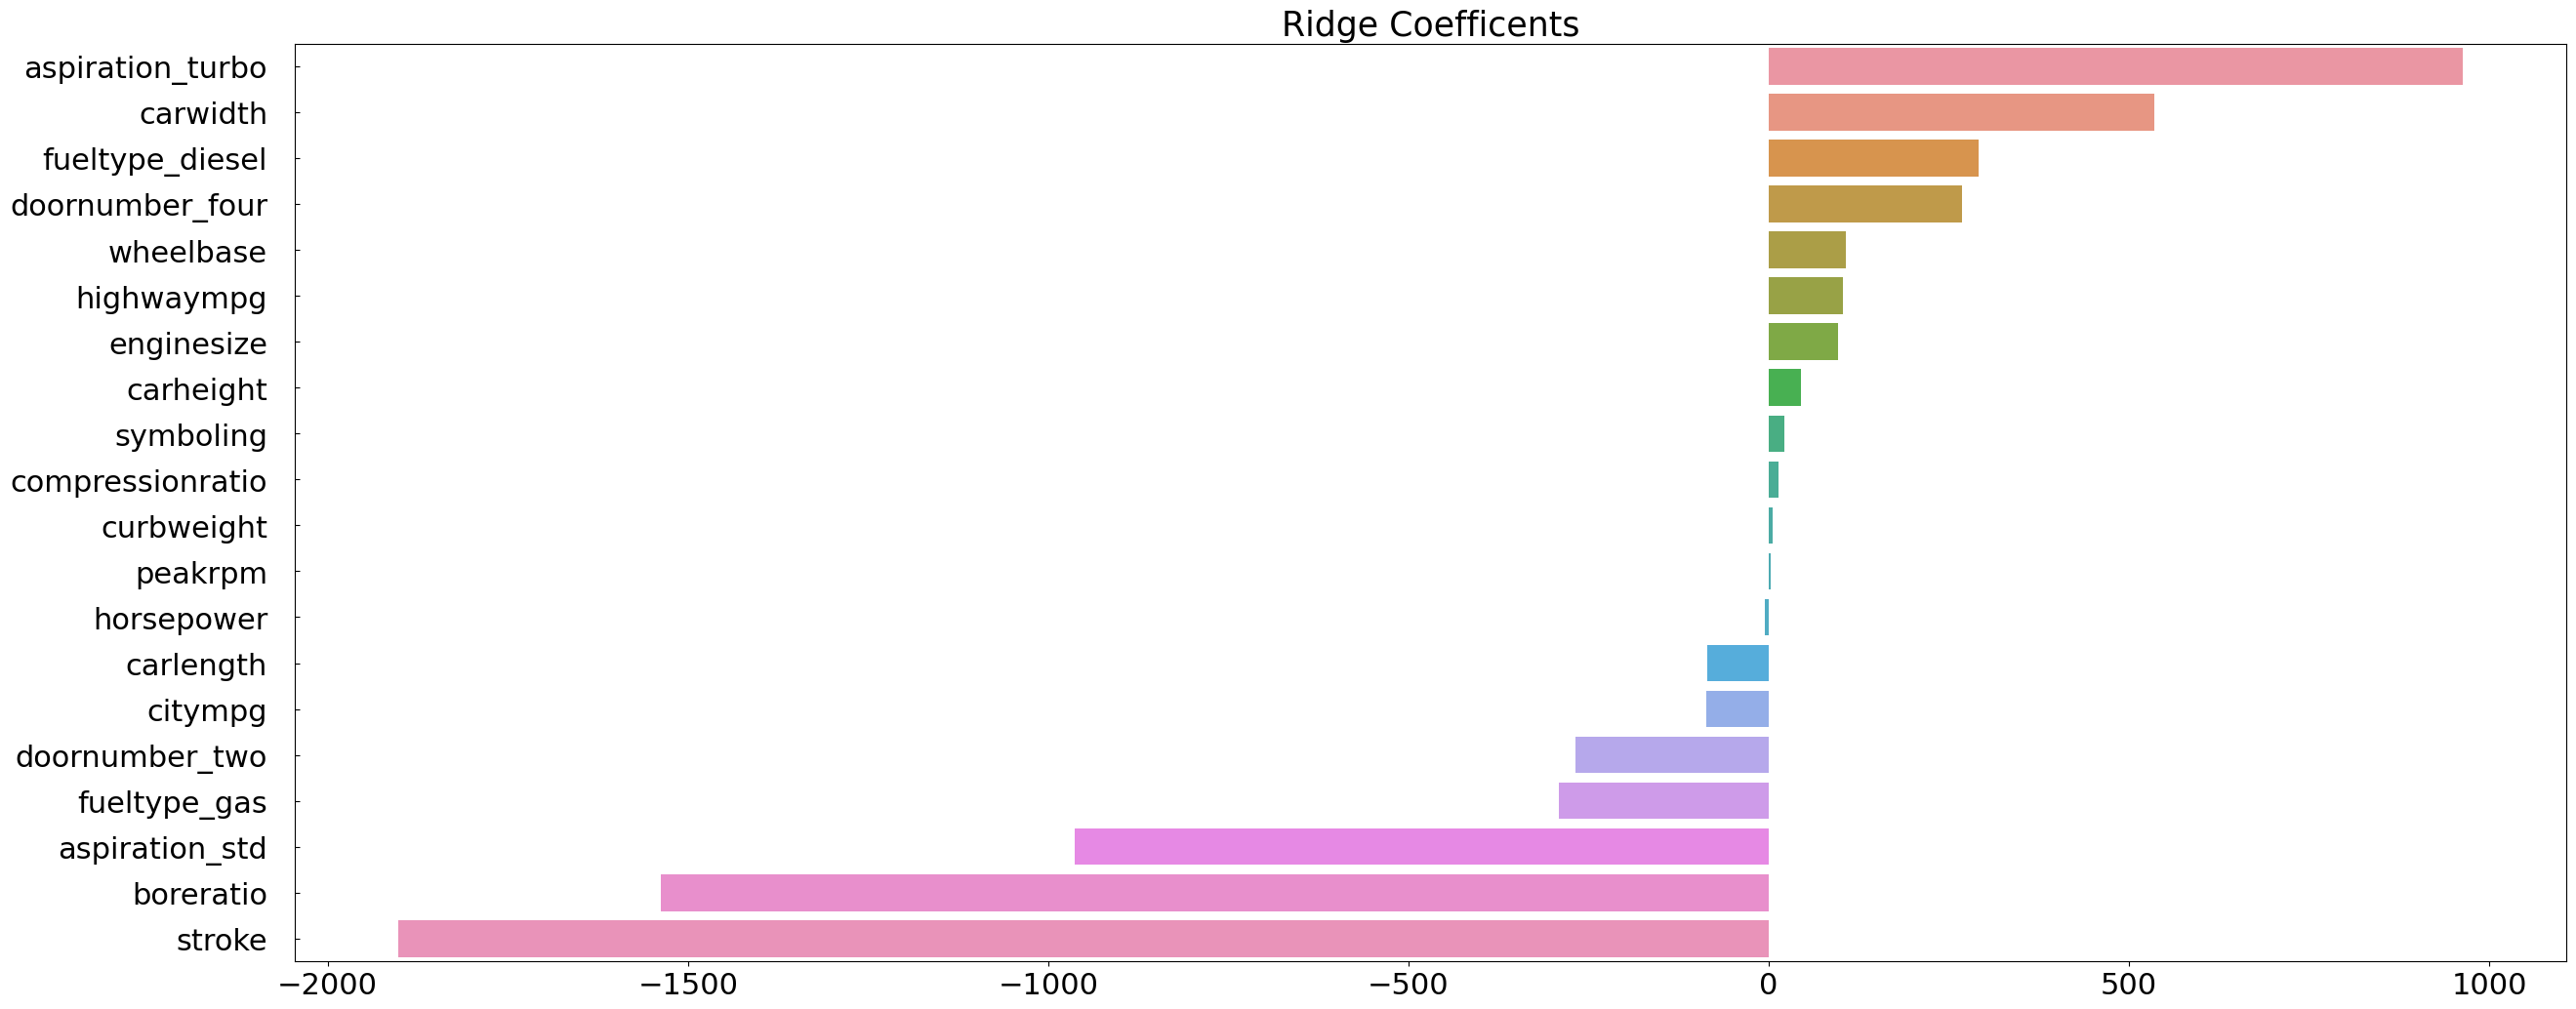

In [38]:
visualize_coefficient(rd_reg, X_features)

## 데이터 편향 문제 확인

In [41]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-1*cross_val_score(
                  model
                , X_features
                , y_target
                , scoring='neg_mean_squared_error'
                , cv=5
            )
        )
        rmse_avg = np.mean(rmse_list)
        print(f'\n{model.__class__.__name__} CV RMSE 값 리스트: {rmse_list}')
        print(f'{model.__class__.__name__} CV 평균 RMSE값 : {rmse_avg:.3f}')
    return

In [43]:
models = [lr_reg, rd_reg]

get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [6714.34860493 3380.5331958  8546.94685588 7431.40285831 5173.04051223]
LinearRegression CV 평균 RMSE값 : 6249.254

Ridge CV RMSE 값 리스트: [4713.69442057 5455.23935887 3857.46258361 4635.80729047 4511.66141157]
Ridge CV 평균 RMSE값 : 4634.773


## 이상치 제거

In [27]:
# 이상치 찾아서 제거
def get_remove_outlier(df=None, weight=1.5):
    columns = car_df.dtypes[car_df.dtypes != 'object'].index.to_list()
    outlier_index = []
    
    for column in columns:
        quantile_25 = np.percentile(column.values, 25) # 25% 위치에 있는 값
        quantile_75 = np.percentile(column.values, 75) # 75% 위치에 있는 값
        iqr = quantile_75 - quantile_25
        iqr_weight = iqr * weight
        lowest_value = quantile_25 - iqr_weight
        highest_value = quantile_75 + iqr_weight
        outlier_index = car_df[(car_df[column] > highest_value) | (car_df[column] < lowest_value)].index
        car_df.drop(outlier_index, axis=0, inplace=True)
        
    return df